## Analyze ArtEmis dataset along some basic axis regarding the emotions indicated & the language characteristics.

#### Assumes you have downloaded the dataset. Please adapt the directory locations for the preprocessed ArtEmis data + the WikiArt images.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
from functools import partial
from ast import literal_eval

from artemis.in_out.basics import show_random_captions
from artemis.emotions import ARTEMIS_EMOTIONS, LARGER_EMOTION_VOCAB, positive_negative_else
from artemis.analysis.emotion_centric import df_to_emotion_histogram, has_emotion_max_dominance
from artemis.evaluation.metaphors import metaphorical_substrings

import os
from os import listdir
from os.path import isfile, join

sns.set()
%load_ext autoreload
%autoreload 2

In [10]:
##
## Change these two directories to your local top-directories.
##
artemis_preprocessed_csv = '/Users/sen/Documents/University/Leiden/3/Advances_Neural_Nets/deep_processed/artemis_preprocessed.csv'
#wikiart_subset_img_dir = '/Users/sen/Documents/University/Leiden/3/Advances_Neural_Nets/wikiart_subset'
wikiart_img_dir = '/Users/sen/Documents/University/Leiden/3/Advances_Neural_Nets/wikiart'
save_figs = False # to save the output figures generated or not.

In [11]:
# Files provided in the code-repo to help the analysis.
glove_vocab_file = '/Users/sen/artemis/artemis/data/glove.6B.100d.vocabulary.txt'
wikiart_genre_labels_file = '/Users/sen/artemis/artemis/data/wiki_art_genre_class.csv'

In [12]:
# load preprocessed file with annotations.
df = pd.read_csv(artemis_preprocessed_csv)
df.tokens = df.tokens.apply(literal_eval) # to make them a python list.
print(f'{len(df)} annotations were loaded from the non-subsetted data-set.')

429431 annotations were loaded from the non-subsetted data-set.


In [15]:
# subset data
subset_folders = 'Analytical_Cubism Cubism Expressionism Fauvism Synthetic_Cubism'

subset_imgfiles = []

for folder in subset_folders.split():
    path = '/Users/sen/Documents/University/Leiden/3/Advances_Neural_Nets/wikiart/' + folder
    subset_imgfiles += [f for f in listdir(path) if isfile(join(path, f))]

subset_imgfiles = [s.strip('.jpg') for s in subset_imgfiles]
intersec = list(set(subset_imgfiles) & set(list(df['painting'])))
df_sub = df
df_sub['bool_index'] = df_sub["painting"].isin(intersec)
df_sub = df_sub.loc[df_sub['bool_index'] == True]
print(f'{len(df_sub)} annotations were loaded from the subsetted data-set.')

41037 annotations were loaded from the subsetted data-set.


In [16]:
# Add a label to indicate if the emotion is positive or negative or Something-Else
df = df.assign(pne = df.emotion.apply(positive_negative_else))
df_sub = df_sub.assign(pne = df.emotion.apply(positive_negative_else))

In [51]:
##
## Basic Stats Full Data
##
print('Basic Stats Full Data')
print('---------------------')
print('Token Length:')
print('Average', df.tokens_len.mean(), 'Median', df.tokens_len.median(), 'Max', df.tokens_len.max())

grouped_artwork = df.groupby(['art_style', 'painting'])
print('Unique paintings annotated:', len(grouped_artwork.size()))
print('Average annotators per painting:', grouped_artwork.size().mean())

##
## Basic Stats Subset Data
##
print('Basic Stats Subset Data')
print('-----------------------')
print('Token Length:')
print('Average', df_sub.tokens_len.mean(), 'Median', df_sub.tokens_len.median(), 'Max', df_sub.tokens_len.max())
grouped_artwork_sub = df_sub.groupby(['art_style', 'painting'])
print('Unique paintings annotated:', len(grouped_artwork_sub.size()))
print('Average annotators per painting:', grouped_artwork_sub.size().mean())


Basic Stats Full Data
---------------------
Token Length:
Average 14.735843476600431 Median 14.0 Max 30
Unique paintings annotated: 80030
Average annotators per painting: 5.365875296763714
Basic Stats Subset Data
-----------------------
Token Length:
Average 14.720106245583255 Median 14.0 Max 30
Unique paintings annotated: 7471
Average annotators per painting: 5.4928389773792


In [21]:
# Unique Tokens Full Data
u_tokens = set()
df.tokens.apply(lambda x: [u_tokens.add(i) for i in x]);
print('Full Data')
print('-----------------------')
print('Upper bound on unique tokens (vocab size). ', len(u_tokens))

# Unique Tokens Subset
u_tokens = set()
df_sub.tokens.apply(lambda x: [u_tokens.add(i) for i in x]);
print('Subset Data')
print('-----------------------')
print('Upper bound on unique tokens (vocab size). ', len(u_tokens))

Full Data
-----------------------
Upper bound on unique tokens (vocab size).  35410
Subset Data
-----------------------
Upper bound on unique tokens (vocab size).  15069


In [32]:
##
## Enrich the Dataframe with meta-data.
##

# Add art-genre labels from WikiArt (not all artworks have this). Makes new data-frame.
genre_info = pd.read_csv(wikiart_genre_labels_file)
df_with_genre = pd.merge(df, genre_info, on=['art_style', 'painting'])
print('-----------------------')
print('Full Data')
print('-----------------------')
print('Not all paintings have a genre label, the reduced set of ArtEmis on those who have is', len(df_with_genre))
print('Percentages of ArtEmis utterances in each art-genre:')
print(genre_info.groupby('genre').describe()['art_style']['count'] / len(genre_info))

# Create genre info for Subset Data 
genre_intersec = list(set(subset_imgfiles) & set(list(genre_info['painting'])))
genre_info_sub = genre_info
genre_info_sub['bool_index'] = genre_info_sub["painting"].isin(intersec)
genre_info_sub = genre_info_sub.loc[genre_info_sub['bool_index'] == True]
df_sub_with_genre = pd.merge(df_sub, genre_info_sub, on=['art_style', 'painting'])
print('-----------------------')
print('Subset Data')
print('-----------------------')
print('Not all paintings have a genre label, the reduced set of ArtEmis on those who have is', len(df_sub_with_genre))
print('Percentages of ArtEmis utterances in each art-genre:')
print(genre_info_sub.groupby('genre').describe()['art_style']['count'] / len(genre_info_sub))

-----------------------
Full Data
-----------------------
Not all paintings have a genre label, the reduced set of ArtEmis on those who have is 341739
Percentages of ArtEmis utterances in each art-genre:
genre
abstract_painting     0.0764366
cityscape             0.0708208
genre_painting         0.167074
illustration          0.0292638
landscape              0.205524
nude_painting         0.0295869
portrait                0.21714
religious_painting     0.100592
sketch_and_study      0.0606662
still_life            0.0428956
Name: count, dtype: object
-----------------------
Subset Data
-----------------------
Not all paintings have a genre label, the reduced set of ArtEmis on those who have is 29557
Percentages of ArtEmis utterances in each art-genre:
genre
abstract_painting     0.0259785
cityscape             0.0722203
genre_painting         0.200208
illustration          0.0277104
landscape              0.126948
nude_painting          0.095601
portrait                0.30291
religiou

In [9]:
# for use on smaller wikiart subset data

# collect folder names and filter data

#dict_lst, file_lst = [], []

#for root, dirs, files in os.walk("/Users/sen/Documents/University/Leiden/3/Advances_Neural_Nets/wikiart_subset", topdown=False):
#    for name in dirs:
#        dict_lst.append(os.path.join(root, name))

#for eachfolder in range(len(dict_lst)):
#    file_lst += [f for f in listdir(dict_lst[eachfolder]) if isfile(join(dict_lst[eachfolder], f))]
#subset_files = [s.strip('.jpg') for s in file_lst]
#intersec = list(set(subset_files) & set(list(df['painting'])))
#df_new = df
#df_new['bool_index'] = df_new["painting"].isin(intersec)
#df_subset = df_new.loc[df_new['bool_index'] == True]

Impressionism claude-monet_mount-kolsaas


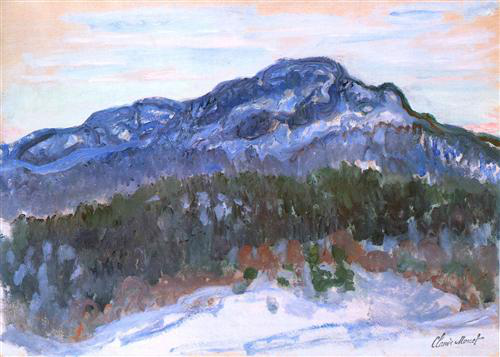

DISGUST:	The colors are okay but the shape of the mountain is all wrong.
CONTENTMENT:	The roughness of the color application. Simple.
SOMETHING ELSE:	The painting looks too rough with its borders and had simple coloring.
FEAR:	I think I would die if I was stranded in an area like this.
SOMETHING ELSE:	The blurry image ruins the visual appeal of the painting.
SOMETHING ELSE:	I don't feel anything because the picture doesn't have anything distinctive.
Expressionism yiannis-tsaroychis_entrance-of-country-house-1928


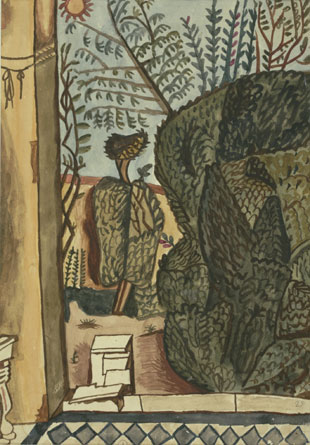

AMUSEMENT:	The sun looks like it came from a cartoon since it has perfect rays circling it
EXCITEMENT:	The tiles feel exotic, feelings of travel and adventure
SOMETHING ELSE:	Colors are pale and the image is mostly dark. Items portrayed are simplistic.
DISGUST:	The colors are too dark and the shapes really are not very life like.


In [41]:
# for use on original full wikiart data use df instead of df_subset
show_random_captions(df, wikiart_img_dir)

# for use on smaller wikiart subset data change df to df_subset
show_random_captions(df_subset, wikiart_img_dir)


Rococo joshua-reynolds_portrait-of-emma-countess-of-mount-edgcumbe


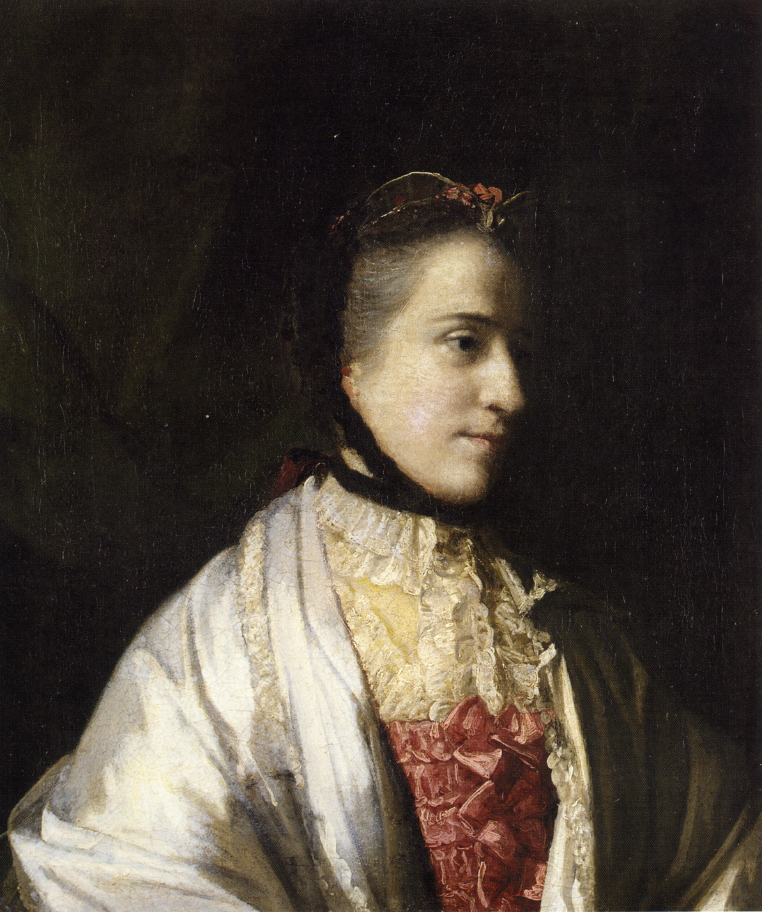

SADNESS:	This woman seems tired and disinterested with what is going on
SADNESS:	the back ground is too dark for this picture. you cannot see her hat on her head
SOMETHING ELSE:	I like the intricacy of the dress and the shadows. But, there's not much in the painting to really look at.
FEAR:	The shadows on her face obscure her just enough to make this look like a painting you can find in a haunted house movie
Expressionism dimitris-mytaras_female-figure


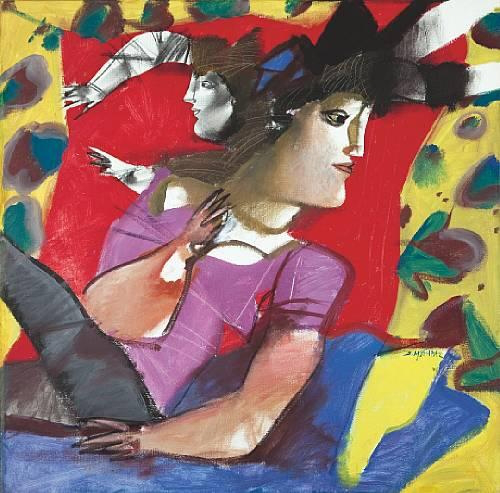

AMUSEMENT:	The angle of the limbs and the person swimming through the air invoke a feeling of play.
DISGUST:	the double face and the weird drawing of this piece gives me a weird feeling.
DISGUST:	The characters look odd and a bit grotesque in the way they are painted.
FEAR:	The head with two faces reminds me of a nightmare
SOMETHING ELSE:	The way there's a second face on the woman's head makes it look like she's having a battle within herself. It creates a sense of agitation.


In [42]:
# for use on original full wikiart data

# Show captions for a random portait.
sb = df_with_genre[df_with_genre.genre == 'portrait']
show_random_captions(sb, wikiart_img_dir)

# Show captions for a random portait.
sb = df_sub_with_genre[df_sub_with_genre.genre == 'portrait']
show_random_captions(sb, wikiart_img_dir)

# for use on smaller wikiart subset data

# filter data and create subset
#genre_intersec = list(set(subset_files) & set(list(df_with_genre['painting'])))
#df_new_with_genre = df_with_genre
#df_new_with_genre['bool_index'] = df_new_with_genre["painting"].isin(genre_intersec)
#df_subset_with_genre = df_new_with_genre.loc[df_new_with_genre['bool_index'] == True]
#df_subset_with_genre[df_subset_with_genre.genre == 'portrait']

#sb = df_subset_with_genre[df_subset_with_genre.genre == 'portrait']
#show_random_captions(sb, wikiart_subset_img_dir)

[<Figure size 864x288 with 1 Axes>, <Figure size 576x288 with 1 Axes>]

<Figure size 432x288 with 0 Axes>

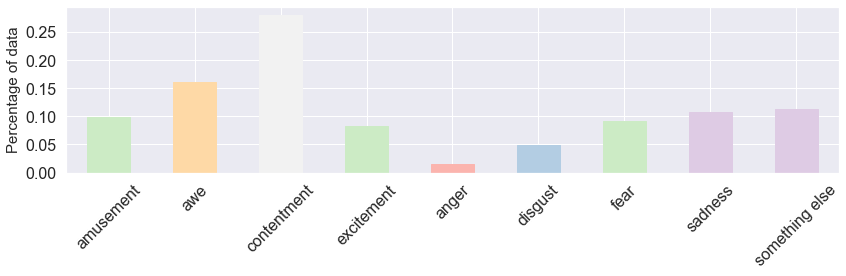

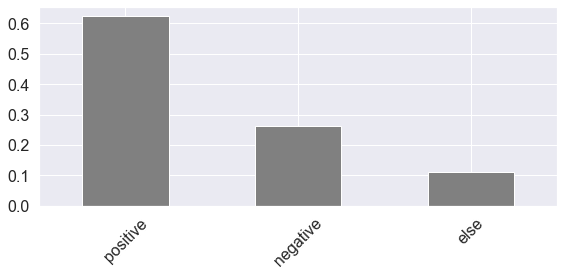

<Figure size 432x288 with 0 Axes>

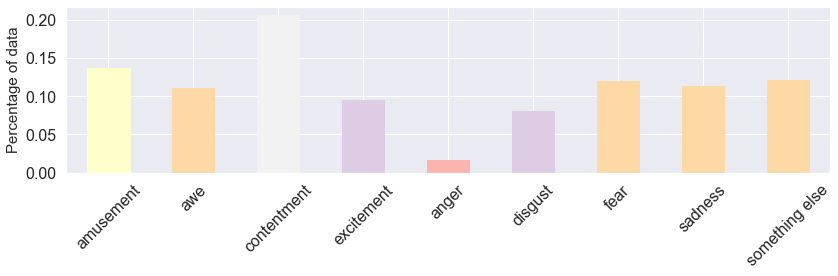

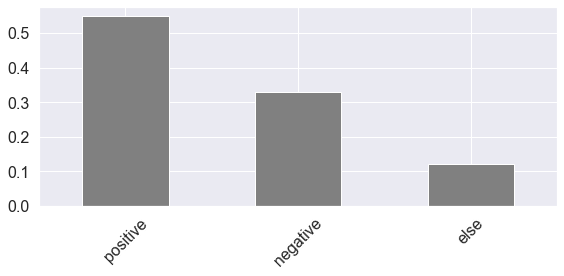

In [43]:
##
## make a histogram of the emotions
##
df_to_emotion_histogram(df)

# histogram for subset data
df_to_emotion_histogram(df_sub)

In [48]:
print('-----------------------')
print('Full Data')
print('-----------------------')
print(df.groupby('pne')['emotion'].count() / len(df))

print('-----------------------')
print('Subset Data')
print('-----------------------')
print(df_sub.groupby('pne')['emotion'].count() / len(df_sub))

-----------------------
Full Data
-----------------------
pne
0    0.623788
1    0.263810
2    0.112402
Name: emotion, dtype: float64


In [53]:
## Quick analysis on emotions and subjectivity.  (this can take up to a minute!)
has_pos_feels = grouped_artwork.apply(lambda group: 0 in group.pne.unique())
has_neg_feels = grouped_artwork.apply(lambda group: 1 in group.pne.unique())
has_else_feels = grouped_artwork.apply(lambda group: 2 in group.pne.unique())

c1 = (has_pos_feels & has_neg_feels)
c2 = (has_pos_feels & has_else_feels)
c3 = (has_neg_feels & has_else_feels)

stat1 = (c1).mean().round(2)
stat2 = (c1|c2|c3).mean().round(2)

print('---------------------')
print('Full Data')
print('---------------------')
print('Percent of artworks annotated with emotions that are POS _and_ NEG', stat1)
print('Percent of artworks annotated with emotions that are ELSE&NEG or ELSE&POS or NEG&POS', stat2)
#Percent of artworks annotated with emotions that are POS _and_ NEG 0.59
#Percent of artworks annotated with emotions that are ELSE&NEG or ELSE&POS or NEG&POS 0.77


## Quick analysis on emotions and subjectivity.  (this can take up to a minute!)
has_pos_feels = grouped_artwork_sub.apply(lambda group: 0 in group.pne.unique())
has_neg_feels = grouped_artwork_sub.apply(lambda group: 1 in group.pne.unique())
has_else_feels = grouped_artwork_sub.apply(lambda group: 2 in group.pne.unique())

c1 = (has_pos_feels & has_neg_feels)
c2 = (has_pos_feels & has_else_feels)
c3 = (has_neg_feels & has_else_feels)

stat1 = (c1).mean().round(2)
stat2 = (c1|c2|c3).mean().round(2)
print('---------------------')
print('Subset Data')
print('---------------------')
print('Percent of artworks annotated with emotions that are POS _and_ NEG', stat1)
print('Percent of artworks annotated with emotions that are ELSE&NEG or ELSE&POS or NEG&POS', stat2)


---------------------
Full Data
---------------------
Percent of artworks annotated with emotions that are POS _and_ NEG 0.59
Percent of artworks annotated with emotions that are ELSE&NEG or ELSE&POS or NEG&POS 0.77
---------------------
Subset Data
---------------------
Percent of artworks annotated with emotions that are POS _and_ NEG 0.64
Percent of artworks annotated with emotions that are ELSE&NEG or ELSE&POS or NEG&POS 0.82


In [58]:
#
# Majority-dominance in emotions (this can take up to a minute!)
#

# Find artworks where one emotion was indicated by
# at least half the annotators of that artwork.
emo_domi = grouped_artwork.apply(has_emotion_max_dominance)
print('Full Data')
print('---------------------')
print('Mean Emotion Domindance: {}, Sum Emotional Dominance: {}'.format(emo_domi.mean(), emo_domi.sum()))
#print(emo_domi.mean(), emo_domi.sum())

print('')
print('Subset Data')
print('---------------------')
emo_domi_sub = grouped_artwork_sub.apply(has_emotion_max_dominance)
print('Mean Emotion Domindance: {}, Sum Emotional Dominance: {}'.format(emo_domi_sub.mean(), emo_domi_sub.sum()))
#print(emo_domi_sub.mean(), emo_domi_sub.sum())

Full Data
---------------------
Mean Emotion Domindance: 0.5190303636136449, Sum Emotional Dominance: 41538

Subset Data
---------------------
Mean Emotion Domindance: 0.4643287377861063, Sum Emotional Dominance: 3469


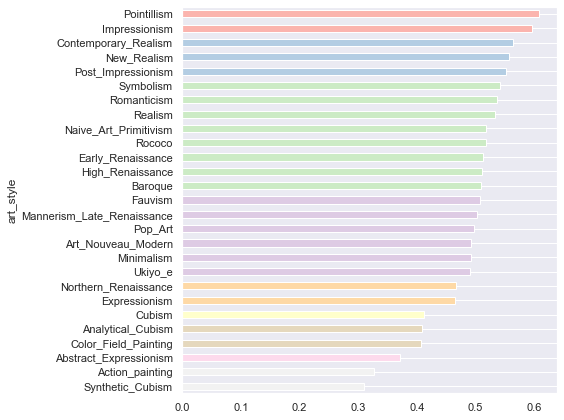

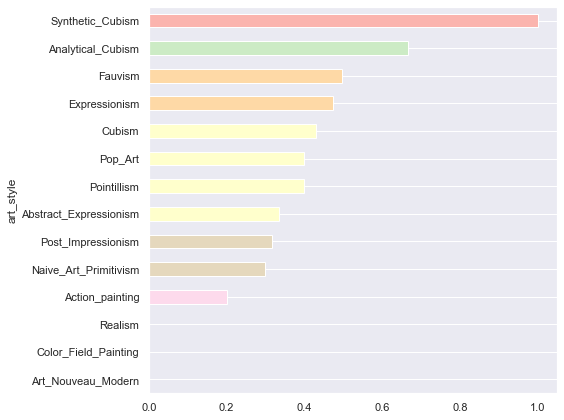

In [60]:
# Plot majority-dominance of emotions per art-style.
s = emo_domi.groupby('art_style').mean().sort_values()
norm = plt.Normalize(s.min(), s.max())
colors = plt.cm.Pastel1_r(norm(s.values))
fig = plt.figure(figsize=(8, 6))
ax = s.plot.barh(color=colors, )
ax.xaxis.grid() # horizontal lines
plt.tight_layout()

s = emo_domi_sub.groupby('art_style').mean().sort_values()
norm = plt.Normalize(s.min(), s.max())
colors = plt.cm.Pastel1_r(norm(s.values))
fig = plt.figure(figsize=(8, 6))
ax = s.plot.barh(color=colors, )
ax.xaxis.grid() # horizontal lines
plt.tight_layout()

if save_figs:
    fig.savefig('emotional_majority_aggreement_per_art_style.jpg')

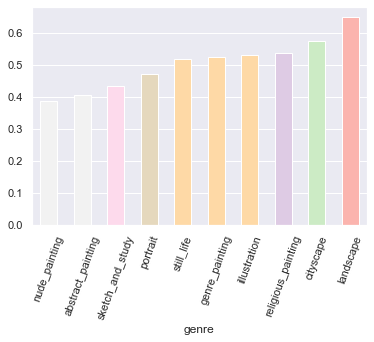

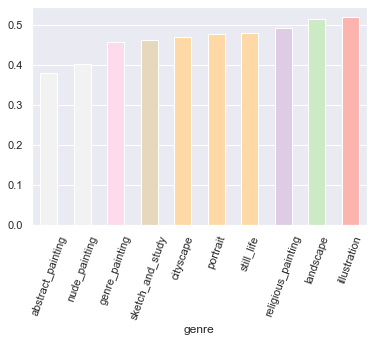

In [63]:
##
## Plot majority-dominance in emotions, per genre.
## 
# (recall - not all artworks have "genre" labels. working here with those that do.)

emo_domi.name = 'majority-aggreement'
temp = pd.merge(emo_domi, genre_info, on=['art_style', 'painting'])
s = temp.groupby('genre').mean().sort_values('majority-aggreement')
s = s['majority-aggreement']
norm = plt.Normalize(s.min(), s.max())
colors = plt.cm.Pastel1_r(norm(s.values))
fig = plt.figure()
ax = s.plot.bar(color=colors, grid=True, rot=70)
ax.xaxis.grid() # horizontal lines


emo_domi_sub.name = 'majority-aggreement'
temp = pd.merge(emo_domi_sub, genre_info_sub, on=['art_style', 'painting'])
s_sub = temp.groupby('genre').mean().sort_values('majority-aggreement')
s_sub = s_sub['majority-aggreement']
norm = plt.Normalize(s.min(), s.max())
colors = plt.cm.Pastel1_r(norm(s.values))
fig = plt.figure()
ax = s_sub.plot.bar(color=colors, grid=True, rot=70)
ax.xaxis.grid() # horizontal lines

if save_figs:
    fig.savefig('emotional_majority_aggreement_per_genre.jpg')

In [65]:
print('---------------------')
print('Full Data')
print('---------------------')
print('Majority-Dominance per genre (fractions).')
print(s)

print('---------------------')
print('Subset Data')
print('---------------------')
print('Majority-Dominance per genre (fractions).')
print(s_sub)

---------------------
Full Data
---------------------
Majority-Dominance per genre (fractions).
genre
nude_painting         0.386977
abstract_painting     0.405405
sketch_and_study      0.432893
portrait              0.470912
still_life            0.516710
genre_painting        0.523672
illustration          0.529973
religious_painting    0.535904
cityscape             0.572430
landscape             0.647187
Name: majority-aggreement, dtype: float64
---------------------
Subset Data
---------------------
Majority-Dominance per genre (fractions).
genre
abstract_painting     0.380000
nude_painting         0.401487
genre_painting        0.457766
sketch_and_study      0.461538
cityscape             0.469388
portrait              0.478134
still_life            0.480412
religious_painting    0.493506
landscape             0.516174
illustration          0.518750
Name: majority-aggreement, dtype: float64


In [66]:
# also now note the emotion that is the dominant (so we can count it per 1 of 9 "emotion" choices)
foo = partial(has_emotion_max_dominance, return_max=True)
emo_domi = grouped_artwork.apply(foo)
has_emo_domi = pd.Series([x[1] for x in emo_domi.values if x[0] == True]) # keeps only paintings where emo-dominance exists

# print the percentages (unormalized and normalized per emotion)
raw_emo_cnt = df.emotion.value_counts().to_dict()
emo_domi_cnt = has_emo_domi.value_counts().to_dict()
for emo in ARTEMIS_EMOTIONS:
    print("{:15}{:8}{:15.4f}".format(emo, emo_domi_cnt[emo], emo_domi_cnt[emo] / raw_emo_cnt[emo]))

amusement          3259         0.0765
awe                5775         0.0836
contentment       18902         0.1567
excitement         1710         0.0481
anger                89         0.0144
disgust             880         0.0415
fear               3988         0.1008
sadness            4309         0.0930
something else     2626         0.0544


In [70]:
# also now note the emotion that is the dominant (so we can count it per 1 of 9 "emotion" choices)
foo = partial(has_emotion_max_dominance, return_max=True)
emo_domi = grouped_artwork_sub.apply(foo)
has_emo_domi = pd.Series([x[1] for x in emo_domi.values if x[0] == True]) # keeps only paintings where emo-dominance exists

# print the percentages (unormalized and normalized per emotion)
raw_emo_cnt = df_sub.emotion.value_counts().to_dict()
emo_domi_cnt = has_emo_domi.value_counts().to_dict()
for emo in ARTEMIS_EMOTIONS:
    print("{:15}{:8}{:15.4f}".format(emo, emo_domi_cnt[emo], emo_domi_cnt[emo] / raw_emo_cnt[emo]))

amusement           459         0.0818
awe                 220         0.0486
contentment        1063         0.1254
excitement          212         0.0543
anger                12         0.0174
disgust             184         0.0557
fear                544         0.1105
sadness             490         0.1060
something else      285         0.0572


In [56]:
is_met = df.utterance_spelled.apply(lambda x: sum([i in x for i in metaphorical_substrings]) >= 1)
print('Percent of annotations making a simile (approximate)', is_met.mean())

print('\nSamples:')
ds = df[is_met].sample(5)
for u in ds.utterance:
    print(u)

Percent of annotations making a simile (approximate) 0.20448919616888395

Samples:
Reminds me of something you may find in England.
The two women embracing each other look like they are happy to see each other finally after a long time
It looks like a dreary existence, dark, damp, and cold - the dominance of grey lends to the overall sadness of the mood.
the ships at mid frame look like a skyline
This make me think of a child drawing on the wall surrounded by lead paint chips ready to be consumed followed by severe illness.


In [71]:
is_met = df_sub.utterance_spelled.apply(lambda x: sum([i in x for i in metaphorical_substrings]) >= 1)
print('Percent of annotations making a simile (approximate)', is_met.mean())

print('\nSamples:')
ds = df_sub[is_met].sample(5)
for u in ds.utterance:
    print(u)

Percent of annotations making a simile (approximate) 0.21385578867850963

Samples:
This is done very well for the style, her face looks good but the legs and feet could be better. Still I am impressed.
The odd dark coloring looks like a looming shadow over a house, it is scary.
This man and his menacing shadow look like they are up to no good.
Look like a party ship with al lthe colors, appears as though streemers are blowing in the wind from the ships. The bright colors are cheerful.
This item is confusing and doesn't really look like anything I recognize.


Token Length per genre/art_style

genre
abstract_painting     14.339026
still_life            14.459752
nude_painting         14.504199
sketch_and_study      14.595872
landscape             14.605013
portrait              14.732299
cityscape             14.790963
religious_painting    14.855221
illustration          15.066015
genre_painting        15.084856
Name: tokens_len, dtype: float64
art_style
Pointillism                   12.992433
Synthetic_Cubism              13.215620
Analytical_Cubism             13.255474
Action_painting               13.274542
New_Realism                   13.445383
Fauvism                       13.571720
Contemporary_Realism          13.614957
Minimalism                    14.062752
Color_Field_Painting          14.094071
Ukiyo_e                       14.137575
Mannerism_Late_Renaissance    14.213860
Early_Renaissance             14.253575
High_Renaissance              14.324301
Pop_Art                       14.410603
Rococo                        14.5623

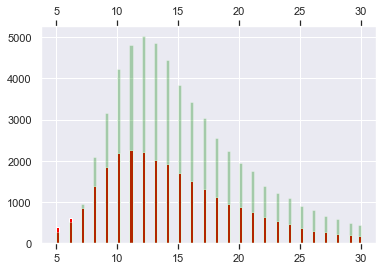

In [57]:
pedandic = True

if pedandic:
    print('Token Length per genre/art_style\n')
    print(df_with_genre.groupby('genre')['tokens_len'].mean().sort_values())
    print(df.groupby('art_style')['tokens_len'].mean().sort_values())
    
    fig, ax = plt.subplots()
    ax2 = ax.twiny()
    df_with_genre[df_with_genre['genre'] == 'abstract_painting']['tokens_len'].hist(bins=100, ax=ax, color='red')
    df_with_genre[df_with_genre['genre'] == 'genre_painting']['tokens_len'].hist(bins=100, ax=ax2, color='green', alpha=0.3)

Token Length per genre/art_style

genre
still_life            14.278486
landscape             14.451982
nude_painting         14.510086
portrait              14.565159
abstract_painting     14.663043
sketch_and_study      14.830549
cityscape             14.951518
illustration          15.048179
genre_painting        15.122969
religious_painting    15.263789
Name: tokens_len, dtype: float64
art_style
Analytical_Cubism         11.933333
Pointillism               13.083333
Fauvism                   13.615136
Action_painting           13.818182
Abstract_Expressionism    14.072464
Pop_Art                   14.153061
Cubism                    14.473382
Post_Impressionism        14.554987
Art_Nouveau_Modern        14.818182
Naive_Art_Primitivism     14.874200
Expressionism             14.908957
Synthetic_Cubism          15.500000
Color_Field_Painting      15.666667
Realism                   16.095238
Name: tokens_len, dtype: float64


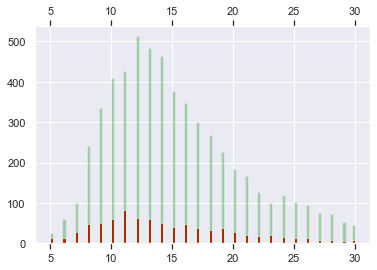

In [74]:
pedandic = True

if pedandic:
    print('Token Length per genre/art_style\n')
    print(df_sub_with_genre.groupby('genre')['tokens_len'].mean().sort_values())
    print(df_sub.groupby('art_style')['tokens_len'].mean().sort_values())
    
    fig, ax = plt.subplots()
    ax2 = ax.twiny()
    df_sub_with_genre[df_sub_with_genre['genre'] == 'abstract_painting']['tokens_len'].hist(bins=100, ax=ax, color='red')
    df_sub_with_genre[df_sub_with_genre['genre'] == 'genre_painting']['tokens_len'].hist(bins=100, ax=ax2, color='green', alpha=0.3)

Number of tokens per utterance (punctuations removed), for utterances with at most 50 tokens (100.00% of all utterances).


Text(0, 0.5, 'Number of utterances')

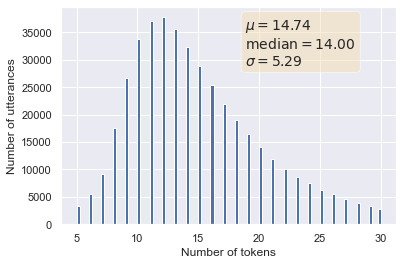

In [58]:
tokens_len = df.tokens_len[df.tokens_len <= 50]
print("Number of tokens per utterance (punctuations removed), for utterances with at most 50 tokens ({:.2f}% of all utterances).".format((df.tokens_len <= 50).mean() * 100))

mu = tokens_len.mean()
median = tokens_len.median()
sigma = tokens_len.std()
textstr = '\n'.join((
    r'$\mu=%.2f$' % (mu, ),
    r'$\mathrm{median}=%.2f$' % (median, ),
    r'$\sigma=%.2f$' % (sigma, )))

ax = tokens_len.hist(bins=100)

# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

# place a text box in upper left in axes coords
ax.text(0.55, 0.95, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

plt.xlabel('Number of tokens', fontsize=12)
plt.ylabel('Number of utterances', fontsize=12)

Number of tokens per utterance (punctuations removed), for utterances with at most 50 tokens (100.00% of all utterances).


Text(0, 0.5, 'Number of utterances')

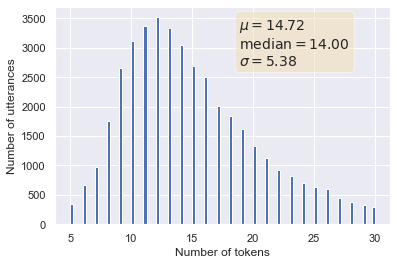

In [75]:
tokens_len = df_sub.tokens_len[df_sub.tokens_len <= 50]
print("Number of tokens per utterance (punctuations removed), for utterances with at most 50 tokens ({:.2f}% of all utterances).".format((df.tokens_len <= 50).mean() * 100))

mu = tokens_len.mean()
median = tokens_len.median()
sigma = tokens_len.std()
textstr = '\n'.join((
    r'$\mu=%.2f$' % (mu, ),
    r'$\mathrm{median}=%.2f$' % (median, ),
    r'$\sigma=%.2f$' % (sigma, )))

ax = tokens_len.hist(bins=100)

# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

# place a text box in upper left in axes coords
ax.text(0.55, 0.95, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

plt.xlabel('Number of tokens', fontsize=12)
plt.ylabel('Number of utterances', fontsize=12)

In [83]:
def rough_fine_grained_emotion_analysis_of_something_else(tokens):
    found_counter = 0
    fine_grained_emotion_category = None
    for t in tokens:        
        for f in LARGER_EMOTION_VOCAB:
            if t in f:
                found_counter += 1
                fine_grained_emotion_category = f[0]
    
    if found_counter == 1: # found_exactly_one
        return fine_grained_emotion_category
    else:
        return 'unclassified'

n_se = (df.emotion == 'something else').sum()
print('Full Data')
print('annotations with something-else choice:', n_se)

print('---------------------')
n_se = (df_sub.emotion == 'something else').sum()
print('Subset Data')

print('annotations with something-else choice:', n_se)

Full Data
annotations with something-else choice: 48269
---------------------
Subset Data
annotations with something-else choice: 4982


In [89]:
se = df[df.emotion == 'something else']
fg_se_emo = se['tokens'].apply(rough_fine_grained_emotion_analysis_of_something_else)
print('Full Data')
print('---------------------')
print('These emotion-words or synnonyms are found exactly once in these many SE annotations:')
print(fg_se_emo.value_counts())


print('---------------------')
print('Subset Data')
print('---------------------')
se = df_sub[df_sub.emotion == 'something else']
fg_se_emo = se['tokens'].apply(rough_fine_grained_emotion_analysis_of_something_else)
print('These emotion-words or synnonyms are found exactly once in these many SE annotations:')
print(fg_se_emo.value_counts())

Full Data
---------------------
These emotion-words or synnonyms are found exactly once in these many SE annotations:
unclassified      33803
confused           4793
bored              3618
curious            3420
happy               597
uncomfortable       321
anxiety             274
nostalgia           270
neutral             256
hope                254
creepy              249
depressing          126
overwhelmed          72
bothered             45
anticipation         45
shock                32
disappointment       27
shy                  14
shame                13
surprised            12
alerted              10
thrilled              4
rage                  4
insult                3
grief                 3
exhilarating          2
empowerment           2
Name: tokens, dtype: int64
---------------------
Subset Data
---------------------
These emotion-words or synnonyms are found exactly once in these many SE annotations:
unclassified      3289
confused           744
curious            